# Consolidação do Conteúdo - Aprendizado de Máquina



***

# Dataset

O tema do dataset escolhido é Pokémon. Os Pokémons são mundialmente conhecidos e são destacados por cada criatura ter suas características únicas que as definem. O dataset escolhido para esse trabalho conta com uma lista de 13 características e 1072 Pokémons.

As características são:
- __Number__ (_Número_): É o ID de cada Pokémon.
- __Name__ (_Nome_): É o nome de cada Pokémon.
- __Type 1__ (_Tipo 1_): É o primeiro tipo do Pokémon. Todo Pokémon têm o primeiro tipo.
- __Type 2__ (_Tipo 2_): É o segundo tipo do Pokémon. Alguns Pokémon não têm segundo tipo.
- __Total__ (_Total_): Soma de todas as estatísticas (Ataque, Defesa, Sp. Ataque, Sp. Defesa e Speed). Este valor é muito importante para determinar se o Pokémon é forte ou não.
- __Attack__ (_Ataque_): Valor da força física do Pokémon.
- __Defense__ (_Defesa_): Valor da resistência física do Pokémon.
- __SP Attack__ (_Ataque Especial_): Valor da força mágica do Pokémon.
- __SP Defense__ (_Defesa Especial_): Valor da resistência mágica do Pokémon.
- __Speed__ (_Velocidade_): Valor da velocidade do Pokémon, esse valor determina qual Pokémon ataca primeiro.
- __Generation__ (_Geração_): A geração de jogos em que o Pokémon teve sua primeira introdução.
- __Legendary__ (_Lendário_): Alguns Pokémons são mais raros que outros, e eles são chamadas de "lendários".
- __Stage__ (_Estágio de Evolução_): Muitos Pokémon tem a capacidade de evoluir para formas mais poderosas. Pokémon que nunca evoluem são considerados básicos (Basic), os que evoluiram 1 vez são Estágio 1 (Stage 1) e os que evoluiram 2 vezes são chamados de Estágio 2 (Stage 2). Existem mecânicas de jogos que dão aos Pokémons novas formas, como as Mega evoluções (Mega) e as formas Gigantamax (Gigantamax).

<br>
<br>

Como pode ser observado pelos dados fornecidos pelo dataset, e pela experiência própria com a franquia do autor deste arquivo de código  com a franquia Pokémon, não é possível afirmar com 100% de acertividade que um Pokémon é do tipo Água, Fogo ou qualquer outro tipo pelas suas estatísticas, sua geração ou se é lendário ou não. Na página do dataset, o próprio autor comenta:


>O tipo de um Pokémon não pode ser inferido apenas pelo seu Ataque e Defesa. Valeria a pena descobrir quais duas variáveis ​​podem definir o tipo de um pokémon, se houver. Duas variáveis ​​podem ser plotadas em um espaço 2D e usadas como exemplo para aprendizado de máquina. Isso pode significar a criação de um exemplo visual que qualquer turma geek de aprendizado de máquina adoraria.

<br>

Entretanto, os Pokémons que pertencem a um certo tipo seguem uma tendência. Segundo o Bulbapedia, um site expecializado em informações da franquia Pokémon, o tipo eletric (elétrico) tem em média 85,94 de velocidade entre todos os Pokémon desse tipo, em contra-partida os do tipo ground (terra) tem somente 61,13 de velocidade. Com essa informações, é possível prever que a probabilidade de um Pokémon que tem 90 de velocidade é maior de ser do tipo elétrico do que terra. Pontanto essa database pode ser uma ótima escolha para testar os algoritmos de aprendizado de máquina.

In [939]:
# Todos os imports global necessários para este arquivo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin, ClassifierMixin
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [940]:
data = pd.read_csv('Pokemon.csv')

In [941]:
# Remover todos os Pokémon na forma Mega ou Gigantamax por ter valores indenticos a sua forma original ou que tenham estatísticas muito distoantes dos outros Pokémon.

data_len_b = len(data)

data = data[~data['stage'].str.contains('Mega')]
data = data[~data['stage'].str.contains('Gigantamax')]


# O Pokémon do indice 1057 possui valores muito distoantes de todos os outros elementos. Então será desconsiderado.

data = data[~data['name'].str.contains('Eternamax ')]

data_len_a = len(data)

print(f"Foram removidos {data_len_b - data_len_a} registros de Pokémons.")

Foram removidos 84 registros de Pokémons.


In [942]:
for column in data.columns:
  print(f'{column:>12}: {len(set(data[column])):4} {data[column].dtype}')

      number:  898 int64
        name:  988 object
       type1:   18 object
       type2:   19 object
       total:  203 int64
          hp:  103 int64
      attack:  118 int64
     defense:  109 int64
   sp_attack:  112 int64
  sp_defense:  105 int64
       speed:  127 int64
  generation:    9 int64
   legendary:    2 bool
       stage:    4 object


***

# Regressão

Com o método da regressão, queremos prever um valor contínuo de variáveis independentes em relação a uma variável dependente. O valor total (total) das estatísticas do Pokémon está relacionado com os valores de todas as estatísticas, então podemos observar que, se um Pokémon tem um valor de ataque (attack) muito alto, é provavel que o seu total (total) também sejá alto.

Para observar essa relação, utilizaremos a regressão linear para prever o valor total (total) de um Pokémon fornecendo somente seu valor de ataque (attack).

### Tratamento dos Dados

Separar os dados da variável independente (X) e os dados da variável dependente (y).

In [943]:
X = data['attack'].values.reshape(-1,1)
y = data['total'].values

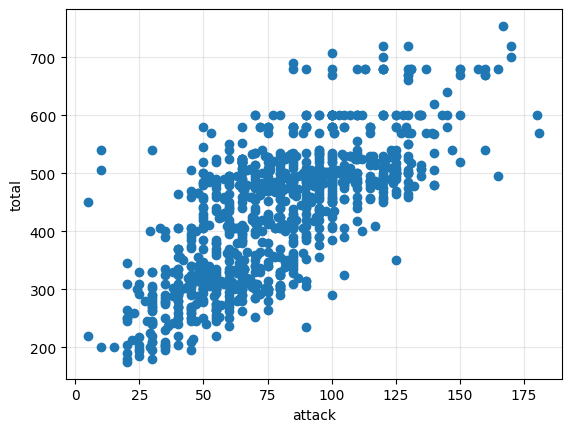

In [944]:
plt.xlabel(f"{data['attack'].name}")
plt.ylabel(f"{data['total'].name}")
plt.scatter(data['attack'], data['total'], zorder=2)
plt.grid(alpha=0.3)
plt.show()

Como os valores dos dados de __X__ e razão de __y__ é alta, será necessário realizar a padronização dos dados de __X__. Será utilizado o StandardScaler() para padronização dos valores.

In [945]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

### Algoritmos

A Raiz do Erro Quadrático Médio (RMSE) é simplesmente a raiz quadrada do MSE. Isso é feito para retornar à métrica à mesma escala que os valores reais, o que facilita a interpretação. 

In [946]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y, ypred):
  mse = mean_squared_error(y, ypred)
  return sqrt(mse)

Abaixo está o algoritmo de Regressão Linear implementado. O algoritmo contém o método fit() para treinar os pesos (w) e utilizá-los posteriormente no método predict(). O algoritmo também contém um método de adição de bias para não ficar preso na origem.

Raiz do Erro Quadrático Médio (RMSE): 79.51881458945789


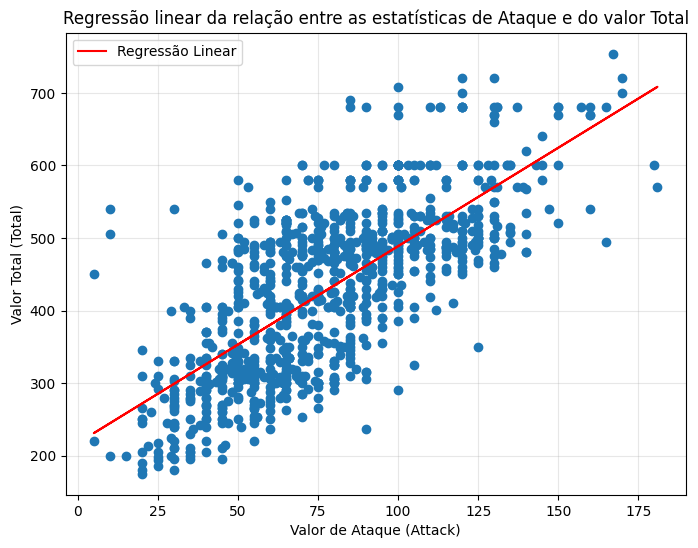

In [947]:
class LinearRegression_I(BaseEstimator, ClusterMixin, TransformerMixin):
  def __init__(self, learning_rate=0.1, n_iter=500):
    self.learning_rate = learning_rate
    self.n_iter = n_iter
    self.w = np.zeros((2,1))
  
  @staticmethod
  def addBias(X):
    bias = np.ones((X.shape[0],1))
    X_b = np.concatenate((bias,X),axis=1)
    return X_b
  
  def fit(self, X, y):
    X_b = self.addBias(X)
    for _ in range(self.n_iter):
      ypred = self.predict(X)
      erro = ypred - y.reshape(-1,1)
      ajuste = X_b.T.dot(erro)/X_b.shape[0]
      self.w = self.w - self.learning_rate * ajuste

  def predict(self, X):
    X_b = self.addBias(X)
    y = X_b.dot(self.w)
    return y



linearRegression_I = LinearRegression_I()
linearRegression_I.fit(X_new, y)
ypred = linearRegression_I.predict(X_new)

print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse(y,ypred)}")
plt.figure(figsize=(8,6))
plt.scatter(X, y, zorder=2)
plt.title("Regressão linear da relação entre as estatísticas de Ataque e do valor Total")
plt.xlabel("Valor de Ataque (Attack)")
plt.ylabel("Valor Total (Total)")
plt.plot(X, ypred, 'r', label="Regressão Linear")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Para fins de comparação, abaixo é importado o modelo LinearRegression() da biblioteca Scikit-learn. Em tese, tanto a implementação quanto o modelo importado devem apresentar os mesmos resultados.

A única diferença encontrada pelo autor deste documento foi a capacidade do modelo de Regressão Linear da biblioteca Scikit-learn de utilizar os dados de entrada (X) sem a necessidade de estarem padronizados. O modelo implementado apresenta problemas de overflow devido à diferença entre a escala dos valores de __X__ e __y__.

Raiz do Erro Quadrático Médio (RMSE): 79.51881458945789


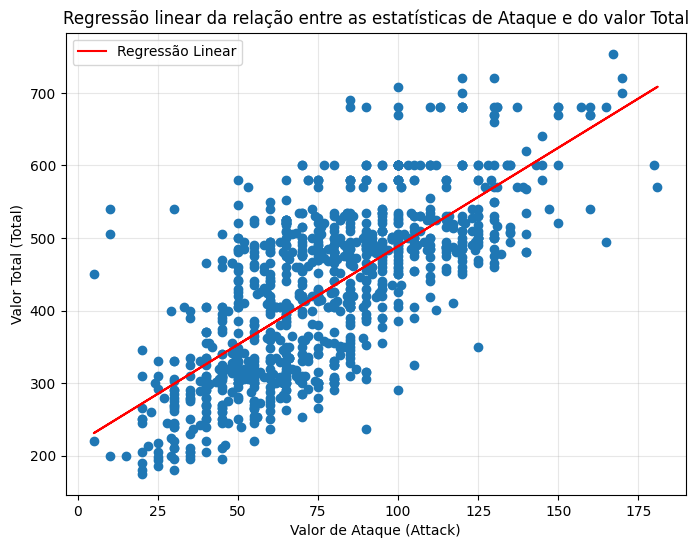

In [948]:
# Regressão Linear do modelo presente em sklearn

from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression()
linearRegression.fit(X, y)
ypred = linearRegression.predict(X)



print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse(y,ypred)}")
plt.figure(figsize=(8,6))
plt.scatter(X, y, zorder=2)
plt.title("Regressão linear da relação entre as estatísticas de Ataque e do valor Total")
plt.xlabel("Valor de Ataque (Attack)")
plt.ylabel("Valor Total (Total)")
plt.plot(X, ypred, 'r', label="Regressão Linear")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Ajuste dos Hiperparâmetros e Validação Cruzada

O algoritmo de Regressão Linear implementado possui dois parâmetros principais: o n_iter, que determina quantas iterações o método fit() realizará durante o treinamento dos pesos (w), e o learning_rate, que define a taxa de aprendizado aplicada em cada iteração.

Por outro lado, o algoritmo da biblioteca do Scikit-learn utiliza estratégias internas otimizadas para obter resultados eficientes. Portanto, não é necessário submetê-lo ao GridSearchCV() para busca de melhores parâmetros, pois essas otimizações já são implementadas internamente.

In [949]:
parameters = {
  'n_iter':[20, 100, 500, 1000],
  'learning_rate': [0.001, 0.01, 0.1]
  }

gs_lr_i_model = GridSearchCV(LinearRegression_I(), parameters, scoring="neg_root_mean_squared_error")
linearReg_I_scores = cross_validate(gs_lr_i_model, X_new, y, scoring="neg_root_mean_squared_error")

linearReg_scores = cross_validate(LinearRegression(), X_new, y, scoring="neg_root_mean_squared_error")

Nos testes de hiperparâmetros e validação cruzada, observou-se que tanto a implementação manual quanto a implementada com o Scikit-learn apresentam desempenhos semelhantes. Portanto, optou-se por utilizar a classe LinearRegression() importada do sklearn.

O modelo LinearRegression utiliza formas automatizadas de configuração dos seus parâmetros para conseguir os melhores resultados, portanto não foi necessário realizar a busca pelos melhores parâmetros do modelo. 

In [951]:
lr_i_mean = linearReg_I_scores['test_score'].mean()
lr_mean = linearReg_scores['test_score'].mean()

print(f'Desempenho médio de RMSE da Regressão Linear (Implementado): {(1 - lr_i_mean):.3f}')
print(f'Desempenho médio de RMSE da Regressão Linear (Scikit-learn): {(1 - lr_mean):.3f}')

Desempenho médio de RMSE da Regressão Linear (Implementado): 80.805
Desempenho médio de RMSE da Regressão Linear (Scikit-learn): 80.806


### Captura e Interpretação dos resultados

Para obter resultados mais confiáveis, os dados serão separados em conjuntos de treinamento e teste.

In [953]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [955]:
linearregression = LinearRegression()
linearregression.fit(X_train, y_train)
ypred = linearregression.predict(X_test)

O modelo treinado com LinearRegression() apresentou um coeficiente de 2,729 e um intercepto de 217,601. Isso indica que, para cada aumento de 1 ponto no atributo de Ataque de um Pokémon, espera-se um acréscimo de aproximadamente 2,729 pontos nas estatísticas Totais, além de uma constante de 217,601 pontos.

In [956]:
print(f'Coeficiente: {linearregression.coef_[0]:.3f}')
print(f'Constante: {linearregression.intercept_:.3f}')

Coeficiente: 2.729
Constante: 217.601


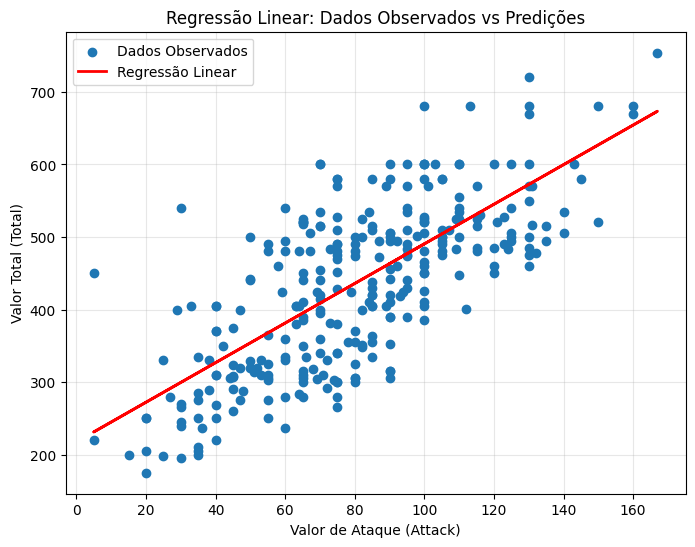

In [957]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, label='Dados Observados', zorder=2)
plt.plot(X_test, ypred, color='red', linewidth=2, label='Regressão Linear')
plt.xlabel("Valor de Ataque (Attack)")
plt.ylabel("Valor Total (Total)")
plt.title('Regressão Linear: Dados Observados vs Predições')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Dado o coeficiente significativo para o Ataque, é possível concluir que esse atributo tem uma influência substancial no Total das estatísticas dos Pokémon no conjunto de dados. Isso sugere que o Ataque (attack) é um preditor crucial para determinar as estatísticas gerais de um Pokémon.

<br>
<br>
<br>
<br>
<br>

***

# Classificação

A classificação é uma forma de aprendizado supervisionado cujo objetivo é prever a categoria de uma nova observação com base em um conjunto de treinamento de observações cujas categorias são conhecidas. Pokémons considerados lendários são geralmente muito poderosos, refletindo em altos valores de estatísticas totais.

Será empregado um algoritmo de classificação para determinar se os Pokémons são ou não lendários com base nas estatísticas totais.

### Classificação Linear

O algoritmo de classificação linear separa as amostras em dois grupos distintos. Por serem distintos, haverá somente dois grupos. Então o processo da classificação desses dois grupos consiste em primeiro construir uma regressão linear e depois é definido um ponto de corte em relação a essa regressão linear, que geralmente é 0,5. Os elementos que estiverem acimaa do corte irão pertencer a classe, enquando os abaixo não.

##### Tratamento dos Dados

Para realizara classificação dos dados, primeiro vamos separar os dados da variável independente (X) e os dados da variável dependente (y).

In [958]:
X = data['total'].values.reshape(-1,1)
y = data['legendary'].values

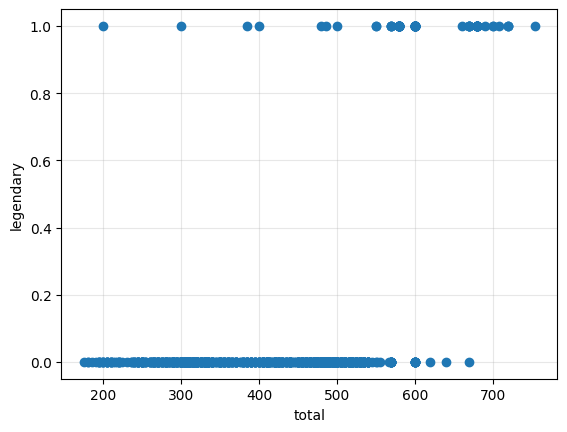

In [960]:
X = data['total'].values.reshape(-1,1)
y = data['legendary'].values
plt.xlabel(f"{data['total'].name}")
plt.ylabel(f"{data['legendary'].name}")
plt.scatter(data['total'], data['legendary'], zorder=2)
plt.grid(alpha=0.3)
plt.show()

##### Algoritmo

Abaixo está o algoritmo de Classificação Linear Binário implementado. O algoritmo realizar a Regressão Linear e, com as previsões, categoriza cada indivíduo como uma das características pela lógica __previsão > 0__.

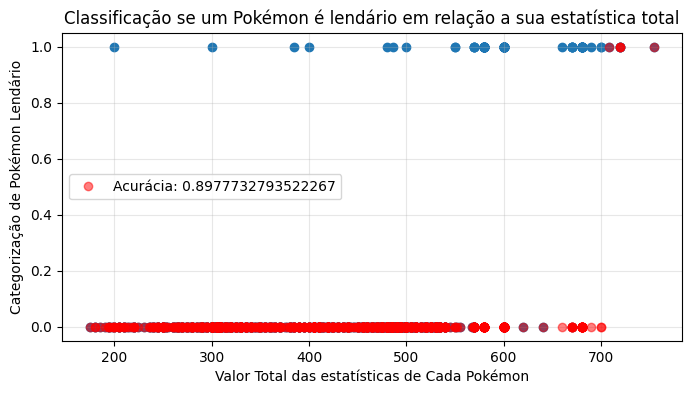

In [961]:
from sklearn.linear_model import LinearRegression


class LogisticRegression_I(BaseEstimator, ClusterMixin, TransformerMixin):
  def __init__(self):
    self.lrmodel = LinearRegression()
  def fit(self,X,y):
    self.lrmodel.fit(X,y)
  def predict(self, X):
    ypred = self.lrmodel.predict(X)
    ypred = (ypred>0.5).astype(int)
    return ypred



logisticregression_I = LogisticRegression_I()
logisticregression_I.fit(X,y)
ypred = logisticregression_I.predict(X)

acuracia = accuracy_score(y, ypred)

plt.figure(figsize=(8,4))
plt.scatter(X, y)
plt.xlabel("Valor Total das estatísticas de Cada Pokémon")
plt.ylabel("Categorização de Pokémon Lendário")
plt.plot(X, ypred,'ro', label=f"Acurácia: {acuracia}", alpha=0.5, zorder=2)
plt.title("Classificação se um Pokémon é lendário em relação a sua estatística total")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Abaixo é implementado o classificador linear da biblioteca do Scikit-learn.

Diferente do modelo de Regressão Linear implementado pelo autor desse documento em comparação ao do Scikit-learn, o algoritmo importado LogisticRegression() é mais preciso (maior acurácia) que o implementado.

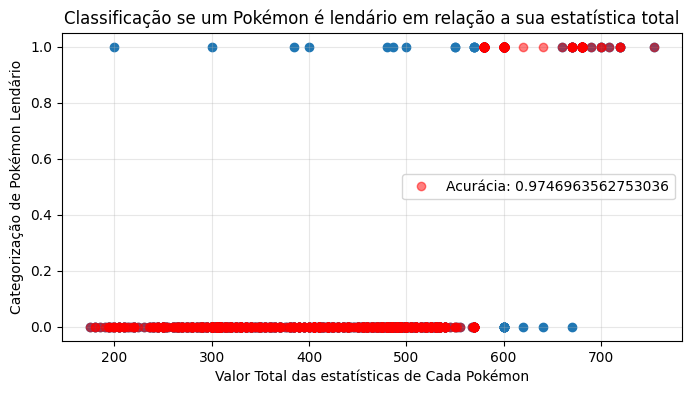

In [962]:
from sklearn.linear_model import LogisticRegression

logisticregression = LogisticRegression()
logisticregression.fit(X,y)
ypred = logisticregression.predict(X)

acuracia = accuracy_score(y, ypred)

plt.figure(figsize=(8,4))
plt.scatter(X, y)
plt.xlabel("Valor Total das estatísticas de Cada Pokémon")
plt.ylabel("Categorização de Pokémon Lendário")
plt.plot(X, ypred,'ro', label=f"Acurácia: {acuracia}", alpha=0.5, zorder=2)
plt.title("Classificação se um Pokémon é lendário em relação a sua estatística total")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

##### Ajuste dos Hiperparâmetros e Validação Cruzada

Neste trabalho não será realizado busca por hiperparâmetros para o algoritmo de Classificação Linear.

Entretanto, para avaliar a capacidade do algoritmo de prever valores que não foram submetidos a testes, é necessário realizar a validação cruzada.

In [963]:
linearClass_I_scores = cross_validate(LogisticRegression_I(), X, y, scoring='accuracy')

linearClass_scores = cross_validate(LogisticRegression(), X, y, scoring='accuracy')


In [964]:
lr_i_mean = linearClass_I_scores['test_score'].mean()
lr_mean = linearClass_scores['test_score'].mean()

print(f'Desempenho médio de Acurácia da Classificação Linear (Implementado): {lr_i_mean:.3f}')
print(f'Desempenho médio de Acurácia da Classificação Linear (Scikit-learn): {lr_mean:.3f}')

Desempenho médio de Acurácia da Classificação Linear (Implementado): 0.899
Desempenho médio de Acurácia da Classificação Linear (Scikit-learn): 0.950


### Captura e Interpretação dos resultados

Nos testes de validação cruzada, o algoritmo importado da biblioteca do Scikit-learn teve melhor desempenho em comparação ao algoritmo implementado, portando para a captura e interpretação dos resultados, será usado o algoritmo do sklearn LogisticRegression().

<br>

Para obter resultados mais confiáveis, os dados serão separados em conjuntos de treinamento e teste.

In [965]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [966]:
logisticregression = LogisticRegression()
logisticregression.fit(X_train, y_train)
ypred = logisticregression.predict(X_test)

Após treinar o modelo LogisticRegression() do Scikit-learn com dados de treino (X_train e y_train), foi obtido uma acurácia de aproximadamente 94% utilizando os dados de testes (X_test e y_test). Os valores do coeficiente e do interceptador encontrados para formar a fronteira de decisão foi respectivamente de 0,04 e -23,203. 

In [967]:
print(f'Coeficiente: {logisticregression.coef_[0][0]:.3f}')
print(f'Constante:  {logisticregression.intercept_[0]:.3f}')
print(f'Acurácia:    {accuracy_score(y_test, ypred):.3f}')

Coeficiente: 0.040
Constante:  -23.203
Acurácia:    0.943


A partir dos coeficientes e do intercepto obtidos, podemos calcular o limiar das estatísticas totais que o algoritmo utiliza para distinguir entre Pokémon lendários e não lendários. De acordo com a fórmula da função logística, podemos determinar o ponto médio da curva sigmoide, onde a probabilidade é igual a 0,5. Esse valor é crucial para o modelo na separação das classificações neste problema binário

In [968]:
print(f'Limiar de corte: {-(logisticregression.intercept_[0] / logisticregression.coef_[0][0]):.3f} pontos de Ataque (attack).')

Limiar de corte: 581.131 pontos de Ataque (attack).


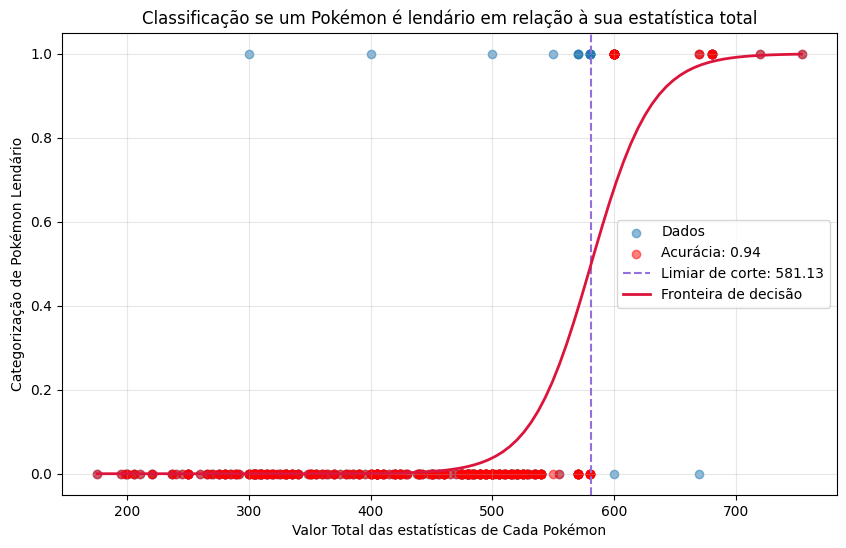

In [969]:
acuracia = accuracy_score(y_test, ypred)
cutoff_point = - logisticregression.intercept_ / logisticregression.coef_[0]
x_line = np.linspace(np.min(X_test), np.max(X_test), 100)
y_line = logisticregression.predict_proba(x_line.reshape(-1, 1))[:, 1]



plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label='Dados', alpha=0.5)
plt.scatter(X_test, ypred, color='red', label=f'Acurácia: {acuracia:.2f}', alpha=0.5)
plt.axvline(x=cutoff_point, color='mediumpurple', linestyle='--', label=f'Limiar de corte: {cutoff_point[0]:.2f}')
plt.plot(x_line, y_line, color='crimson', label='Fronteira de decisão', linewidth=2)
plt.xlabel("Valor Total das estatísticas de Cada Pokémon")
plt.ylabel("Categorização de Pokémon Lendário")
plt.title("Classificação se um Pokémon é lendário em relação à sua estatística total")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

A alta acurácia obtida pelo modelo de classificação linear do Scikit-learn indica que Pokémon com estatísticas totais mais elevadas têm uma maior probabilidade de serem classificados como lendários. O modelo estabeleceu um limiar de corte na curva sigmoide, definido em 581,13, onde todos os Pokémon com estatísticas totais acima desse valor foram classificados como lendários durante os testes. Esses resultados afirma que há uma relação entre a classificação de um Pokémon como lendário e suas estatísticas totais. Portanto, é possível concluir que que as estatísticas totais é um forte indicativo para de determinação da classificação se um Polémon é ou não lendário, conforme previsto pelo modelo de classificação linear utilizado.

<br>
<br>
<br>
<br>
<br>

### K-Nearest Neighbors (KNN)

A ideia principal do KNN (K-Nearest Neighbors) é prever o valor ou a classe de um ponto de dados com base nos pontos de dados mais próximos no espaço de características. No universo Pokémon, os Pokémons do tipo Grama são mágicos e resistentes, e se tornam ainda mais fortes quando evoluem para seu estágio final. No entanto, como se trata de um jogo, a lógica de evolução pode ser alterada em prol da diversão e de outras considerações de desenvolvimento. Isso resulta em situações onde um Pokémon completamente evoluído pode ser mais fraco do que um Pokémon básico ou em estágio intermediário.

O objetivo desta parte do trabalho é classificar corretamente os Pokémons do tipo Grama de acordo com seus estágios evolutivos (Basic, Stage 1 e Stage 2). Será utilizado o algoritmo K-Nearest Classifier, que é a variação do algoritmo K-Nearest Neighbors para problemas de classificação. Para isso, utilizaremos apenas as informações das estatísticas de ataque especial (sp_attack) e pontos de vida (hp), além das informações de estágio do nível evolutivo dos Pokémon.

##### Tratamento dos Dados

Primeiro, precisamos separar os dados de interesse para o treinamento. Os dados de interesse são os Pokémon cujo tipo primário (type1) ou secundário (type2) sejá do tipo __Grama__, não sejam lendários e evoluem do Basic, para o Stage 1 e por fim, Stage 2.

In [970]:
filtered_data = data.loc[
    (data['type1'] == 'Grass') | (data['type2'] == 'Grass') &
    (data['legendary'] == False)
]

In [971]:
selected_pkmn_stages = []

prev1 = None
prev2 = None

for index, pkmn in filtered_data.iterrows():
  if pkmn['stage'] == 'Stage 2':
    if prev2['stage'] == 'Stage 1' and prev1['stage'] == 'Basic':
      selected_pkmn_stages.append(prev1)
      selected_pkmn_stages.append(prev2)
      selected_pkmn_stages.append(pkmn)

  prev1 = prev2 
  prev2 = pkmn

selected_pkmn_stages = pd.DataFrame(selected_pkmn_stages, columns=['number', 'name', 'type1', 'type2', 'total', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'generation', 'legendary', 'stage'])

Para realizar a classificação dos dados, vamos separar as características __pontos de vida__ e __ataque especial__ para serem os dados da variável independente (X) e a __classificação de estágio__ para serem os dados da variável dependente (y).

In [972]:
X = selected_pkmn_stages[['hp', 'sp_attack']].values
y = selected_pkmn_stages['stage'].values

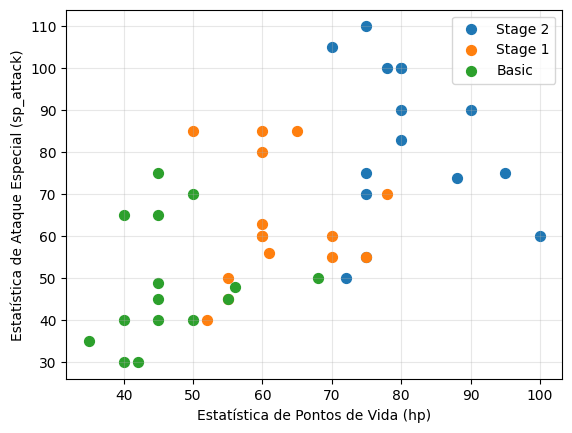

In [973]:
for stage in set(y):
    plt.scatter(X[y == stage, 0], X[y == stage, 1], s=50, label=f'{stage}')
plt.xlabel('Estatística de Pontos de Vida (hp)')
plt.ylabel('Estatística de Ataque Especial (sp_attack)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

##### Algoritmo

O código abaixo representa uma implementação do algoritmo K-Nearest Neighbor (KNN). O método fit() armazena os dados de entrada (X) e seus respectivos alvos (y) que são passados como parâmetros. Na função predict(), o algoritmo calcula a distância Euclidiana entre cada elemento de entrada e os dados de treinamento (self.X). Em seguida, determina a classificação mais frequente entre os vizinhos mais próximos desse elemento para prever a classificação do novo dado de entrada.

In [974]:
class KNeighborsClassifier_I(BaseEstimator, ClusterMixin, TransformerMixin):
  def __init__(self, n_neighbors=3):
    self.n_neighbors = n_neighbors

  def fit(self, X, y):
    self.X = X
    self.y = y
    
  def distance(self, X):
    difference = self.X - X
    squared = difference ** 2
    summed = np.sum(squared, axis=1)
    root = np.sqrt(summed)
    return root
  
  def predict(self, X):
    y_pred = np.empty((X.shape[0],), dtype=object)
    for i in range(X.shape[0]):
      distances = self.distance(X[i])
      nearest_neighbors = np.argsort(distances)[:self.n_neighbors]
      neighbor_labels = self.y[nearest_neighbors]
      unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
      y_pred[i] = unique_labels[np.argmax(counts)]
    return y_pred

O plot do gráfico do KNeighborsClassifier necessita de um bloco de código de tamanho considerável, portanto foi necessário implementar uma função para a impressão do gráfico do algoritmo.

In [975]:
from matplotlib.colors import ListedColormap


def plot_knc(model, X, y, xlim='X1', ylim='X2'):
  ypred = model.predict(X)
  accuracy = accuracy_score(y, ypred)
  
  cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
  cmap_bold = ['darkorange', 'c', 'darkblue']

  mesh_step_size = .1  
  plot_symbol_size = 50

  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                      np.arange(y_min, y_max, mesh_step_size))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  plt.figure()
  unique_classes = np.unique(y)
  class_to_number = {original: number for number, original in enumerate(unique_classes)}
  class_to_color = {original: color for original, color in zip(unique_classes, cmap_bold)}

  Z_num = np.array([class_to_number[class_name] for class_name in Z.ravel()])
  Z_num = Z_num.reshape(Z.shape)
  plt.pcolormesh(xx, yy, Z_num, cmap=cmap_light)

  for stage in unique_classes:
    plt.scatter(X[y == stage][: ,0], 
                X[y == stage][: ,1], 
                s=plot_symbol_size,
                c=class_to_color[stage],
                label=str(stage), 
                edgecolor='black')

  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.xlabel(xlim)
  plt.ylabel(ylim)
  plt.legend()
  plt.show()
  return accuracy

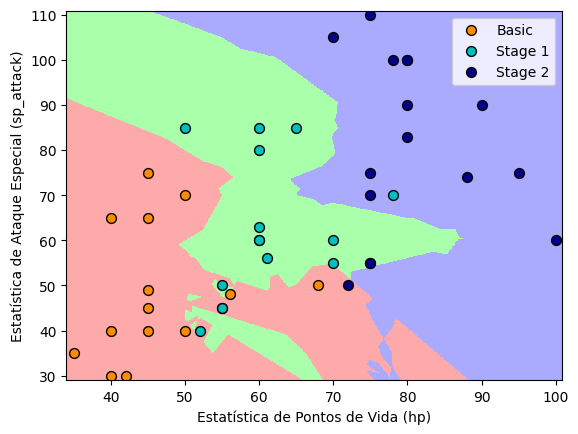

In [976]:
kneighborsclassifier_I = KNeighborsClassifier_I(n_neighbors=3)
kneighborsclassifier_I.fit(X,y)

_ = plot_knc(kneighborsclassifier_I, X, y,
  xlim='Estatística de Pontos de Vida (hp)',
  ylim='Estatística de Ataque Especial (sp_attack)')

Para medir a eficiência do da implementação do algoritmo KNeighborsClassifier acima, será importado o KNeighborsClassifier da biblioteca do Scikit-learn.

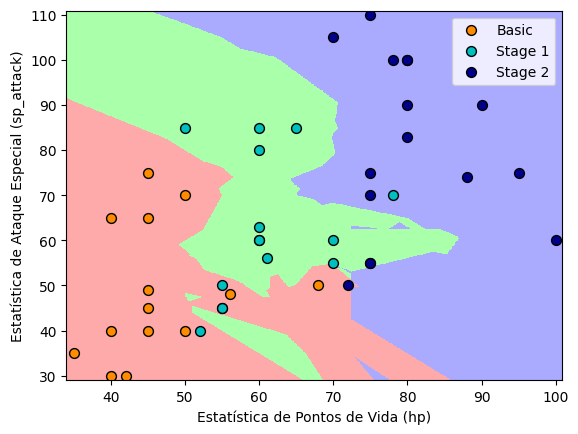

In [977]:
from sklearn.neighbors import KNeighborsClassifier

kneighborsclassifier = KNeighborsClassifier(n_neighbors=3)
kneighborsclassifier.fit(X,y)

_ = plot_knc(kneighborsclassifier, X, y,
  xlim='Estatística de Pontos de Vida (hp)',
  ylim='Estatística de Ataque Especial (sp_attack)')

### Ajuste dos Hiperparâmetros e Validação Cruzada

O algoritmo KNeighborsclassifier possui um parâmetro chamado __n_neighbors__, que determina quantos dos pontos de dados de treinamento mais próximos serão usados para decidir a classe da nova amostra, geralmente pela votação majoritária das classes desses vizinhos. 



In [978]:
parameters = {
  'n_neighbors':[2, 3, 5, 7, 9]
  }

gs_knc_i_model = GridSearchCV(KNeighborsClassifier_I(), parameters, scoring="accuracy")
knclassifier_I_scores = cross_validate(gs_knc_i_model, X, y, scoring="accuracy", cv=5)

gs_knc_model = GridSearchCV(KNeighborsClassifier(), parameters, scoring="accuracy")
knclassifier_scores = cross_validate(gs_knc_model, X, y, scoring="accuracy", cv=5)

Os resultados do desempenho médio da acurácia dos algoritmos KNeighborsClassifier indicaram que o modelo implementado apresentou um desempenho superior em comparação ao modelo importado do Scikit-learn. Portanto, o modelo implementado será utilizado para a captura e interpretação dos dados do problema.

In [979]:
knc_i_mean = knclassifier_I_scores['test_score'].mean()
knc_mean = knclassifier_scores['test_score'].mean()

print(f'Desempenho médio de acurácia da KNeighborsClassifier (implementado): {knc_i_mean:.3f}')
print(f'Desempenho médio de acurácia da KNeighborsClassifier (Scikit-learn): {knc_mean:.3f}')

Desempenho médio de acurácia da KNeighborsClassifier (implementado): 0.667
Desempenho médio de acurácia da KNeighborsClassifier (Scikit-learn): 0.644


Após a escolha do modelo, é necessário determinar qual configuração de parâmetros gera os melhores resultados. Ao utilizar o GridSearchCV, a conclusão que o parâmetro __n_neigbors__ com valor __2__ resultou na melhor acurácia entre as opções.

In [982]:
gs_knc_i_model.fit(X,y)
gs_knc_i_model.best_params_, gs_knc_i_model.best_score_

({'n_neighbors': 2}, 0.7777777777777777)

### Captura e Interpretação dos resultados

Na etapa anterior foi definido qual o algoritmo a ser utilizado (do Scikit-learn ou implementado) e os parâmetros ideais para o exercício de classificação. Nesta etapa será realizado o treinamento e aplicado o teste do modelo.

In [983]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [985]:
# Treinamento do modelo com os dados de treinamento.

kneighborsclassifier_I = KNeighborsClassifier_I(n_neighbors=2)
_ = kneighborsclassifier_I.fit(X_train, y_train)

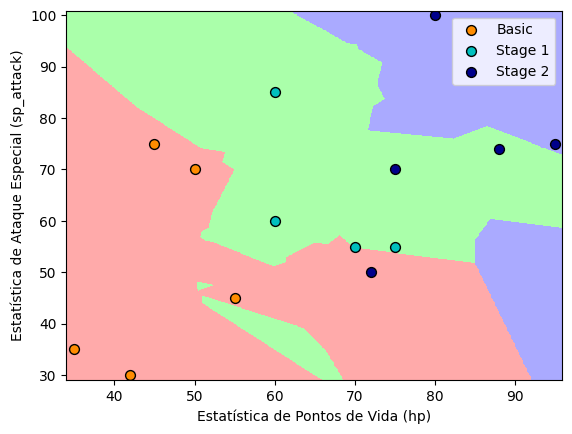

Acucária: 0.7857142857142857


In [986]:
ypred = kneighborsclassifier_I.predict(X_test)

accuracy = plot_knc(kneighborsclassifier_I, X_test, y_test,
  xlim='Estatística de Pontos de Vida (hp)',
  ylim='Estatística de Ataque Especial (sp_attack)')

print(f'Acucária: {accuracy}')

Para que um jogo eletrônico seja desafiador e motivador, é essencial criar dificuldades e desafios para os jogadores. Se todos os Pokémon evoluíssem de maneira linear, o jogo se tornaria previsível e, consequentemente, menos interessante. A análise mostrou uma acurácia de 78% na classificação dos Pokémon nos estágios Basic, Stage 1 e Stage 2, baseada nas estatísticas de ataque especial (sp_attack) e pontos de vida (hp). Isso indica que esses valores não aumentam proporcionalmente conforme o nível evolutivo, contribuindo para a imprevisibilidade e a complexidade do jogo, apesar de ser um forte indício de classificação entre os estágios evolutivos.

<br>
<br>
<br>
<br>
<br>

***

# Árvore de Decisão

Uma árvore de decisão é um modelo preditivo usado em aprendizado de máquina que representa uma série de decisões e suas possíveis consequências, incluindo resultados, custos e utilidades.

### Tratamento dos Dados

Os algoritmos de árvores de decisão podem classificar dados com características discretas ou contínuas. No entanto, se for necessário classificar dados que contenham ambos os tipos de características, é essencial tratar os dados previamente. As árvores de decisão são algoritmos de aprendizado de máquina sensíveis aos dados de entrada, exigindo algumas etapas de pré-processamento. Como em todos os algoritmos utilizados neste trabalho, a primeira etapa envolve separar os dados de entrada (X) das respostas (y).

Neste cenário, o objetivo é classificar e prever os estágios (Baby, Basic, Stage 1 e Stage 2) dos Pokémon com base nas seguintes informações: type1, type2, total, hp, attack, defense, sp_attack, sp_defense e speed. Essas informações formam os dados de entrada (X), enquanto os estágios dos Pokémon constituem as respostas (y).

In [1012]:
X = data
y = data['stage']

A função UnwantedColumns() remove todas as colunas que não serão usadas dos dados de entrada (X). Para este exercício, nem os dados da coluna 'number' e nem os da coluna 'name' (que é o próprio y) serão usados em __X__.

In [1013]:
class UnwantedColumns(BaseEstimator, TransformerMixin):
  def fit( self, X, y=None):
    self.unwantedColumns = ['number', 'name', 'stage','generation', 'legendary']
    return self
  def transform(self, X, y=None):
    return X.drop(self.unwantedColumns, axis=1)

As árvores de decisão são sensíveis a dados de entrada mistos, ou seja, que contêm tanto dados numéricos quanto categóricos. Para lidar com essa questão, é necessário separar as colunas nesses dois grupos e tratá-los de forma independente.

In [1014]:
class NumberColumns(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.numberColumns = X.select_dtypes(include='number').columns
    return self
  def transform(self, X, y=None):
    return X[self.numberColumns]

Além de separar as colunas numéricas, também é necessário padronizar os valores, pois os algoritmo de árvore de decisão podem se tornar menos eficiêntes com valores dispersos ou muito diferentes entre as colunas. Para isso, será utilizado o StandardScaler() da biblioteca do Scikit-learn.

In [1015]:
pipe_num = Pipeline([
  ('numbers_columns', NumberColumns()),
  ('scaler', StandardScaler())
])

Agora é separado os dados categóricos para serem tratados.

In [1016]:
class CategoricColumns(BaseEstimator, TransformerMixin):
  def fit(self, X , y=None):
    self.categoricColumns = X.select_dtypes(include='object').columns
    return self
  def transform(self, X, y=None):
    return X[self.categoricColumns]

Além de separar as colunas com dados categóricos, é necessário binarizar essas informações em uma matriz esparsa. Os algoritmos de árvore de decisão podem interpretar categorias numéricas como categorias hierarquizadas, o que pode enviesar a classificação. Para evitar isso, utiliza-se o OneHotEncoder(), que transforma cada coluna de dados categóricos em uma matriz esparsa.

In [1017]:
pipe_cat = Pipeline([
  ('categorics_columns', CategoricColumns()),
  ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
  ('encoder', OneHotEncoder())
])

Após o tratamento dos dados numéricos e categóricos, é necessário unir esses dados, garantindo que todas as informações estejam padronizadas e numerizadas. Isso pode ser feito utilizando a função FeatureUnion, como no código abaixo:

In [1018]:
columns_union = FeatureUnion([
  ('pipe_num', pipe_num),
  ('pipe_cat', pipe_cat)
])

Este código implementa um pipeline completo para o preprocessamento dos dados. Inicia-se com a remoção das colunas indesejadas, seguida pela união das transformações aplicadas às características numéricas e categóricas. Esse pipeline, denominado pre_proc, encapsula todas as etapas necessárias para preparar os dados de forma eficiente para modelos de machine learning, garantindo consistência e organização no tratamento das informações.

In [1019]:
pre_proc = Pipeline([
  ('Unwanted_columns', UnwantedColumns()),
  ('columns_union', columns_union)
])

##### Algoritmo

No bloco de código abaixo importa o algoritmo de Árvore de decisão da biblioteca do Scikit-learn.

In [1020]:
from sklearn.tree import DecisionTreeClassifier

Abaixo está a implementação para gerar o gráfico de uma árvore de decisão. Os parâmetros são:
- __tree__: o modelo treinado.
- __class_names__: os nomes das classes (funciona como esperado apenas para dados de entrada onde todas as características são categóricas; caso contrário, é recomendado não fornecer valores para este parâmetro).
- __feature_names__: os nomes das características (nós da árvore).
- __image_name__: o nome do arquivo PNG gerado.

In [1021]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus


def plot_tree(tree, feature_names, image_name, class_names=None):
  dot_data = StringIO()
  export_graphviz(tree, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True,
                  feature_names=feature_names,
                  class_names=class_names)

  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
  graph.set_size('"200,200!"')
  graph.write_png(f'Image/{image_name}.png')
  Image(graph.create_png())

O algoritmo de aprendizado de máquina DecisionTreeClassifier é então a um pipeline que realiza o pré processamento dos dados de entrada com o a árvore de decisão. No mesmo bloco de código é listado todos os nomes das __feature_names__, que são os nós de decisão do modelo. Como é um problema que envolve características categóricas e numéricas, não é recomendável utilizar __class_names__ para nomear as folhas resultades (recomendação do Scikit-learn).

In [1022]:
pipe_decision_tree = Pipeline([
  ('preproc', pre_proc),
  ('tree', DecisionTreeClassifier(max_depth=5))
])

pipe_decision_tree.fit(X,y)
ypred = pipe_decision_tree.predict(X)
print(f'Acurácia: {accuracy_score(y, ypred):.3f}')


X_cat = X[['type1','type2']]
u_numbers = ['total', 'hp', 'attack', 'defense', 'sp_attack','sp_defense', 'speed']
u_type1 = X_cat['type1'].unique()
u_type2 = X_cat['type2'].unique()
feature_names = [*u_numbers, *u_type1, *u_type2]

class_names = [*y]

plot_tree(pipe_decision_tree.named_steps['tree'],feature_names,'graph_DecisionTreeClassifier_0')

Acurácia: 0.767


![Gráfico da Árvore de decisão](Image/graph_DecisionTreeClassifier_0.png)

### Ajuste dos Hiperparâmetros e Validação Cruzada

O modelo de árvore de decisão do Scikit-learn possui vários parâmetros que modificam o comportamento do algoritmo. Para este trabalho, utilizaremos especificamente os parâmetros __criterion__ e o __max_depth__.

No código abaixo, utilizamos o GridSearchCV para testar diferentes configurações dos parâmetros criterion e max_depth. Além disso, utilizamos o cross_validate para avaliar a capacidade preditiva do modelo em relação aos valores de __y__ utilizando os dados de entrada __X__. O uso de GridSearchCV permite encontrar a melhor combinação de parâmetros para otimizar a acurácia do modelo.

In [1023]:
parameters = {
  'tree__criterion': ['gini','entropy'],
  'tree__max_depth': [3, 5, 10, 15],
  }

gs_dt_model = GridSearchCV(pipe_decision_tree, parameters, scoring="accuracy", cv=3)
decisiontree_scores = cross_validate(pipe_decision_tree, X, y, scoring="accuracy", cv=3)

O resultado médio da acurácia obtido com o cross_validate está entre 0,6 a 0,7, dependendo da forma em que os Kfolds são randomizados.

In [1024]:
df_mean = decisiontree_scores['test_score'].mean()
print(f'Desempenho médio de acurácia da DecisionTreeClassifier (Scikit-learn): {df_mean:.3f}')

Desempenho médio de acurácia da DecisionTreeClassifier (Scikit-learn): 0.697


O resultado apresentado pelo GridSearchCV indica que, na maioria das execuções realizadas pelo autor deste trabalho, as configurações para o __criterion__ a estratégia _gini_ e o __max_depth__ em _5_ é a configuração que demostra melhores valores obtidos de acurácia.

In [1028]:
gs_dt_model.fit(X,y)
dt_criterion = gs_dt_model.best_params_['tree__criterion']
dt_max_depth = gs_dt_model.best_params_['tree__max_depth']
print(f'Melhor estratégia de impureza para o criterion: {dt_criterion}\nMelhor configuração de max_depth: {dt_max_depth}\nAcurácia alcançada com essa configuração: {gs_dt_model.best_score_:.3f}')

Melhor estratégia de impureza para o criterion: gini
Melhor configuração de max_depth: 5
Acurácia alcançada com essa configuração: 0.702


### Captura e Interpretação dos resultados

Na etapa anterior foi defino qual algoritmo (do Scikit-learn ou implementado) e os parâmetros ideais a serem ser utilizados no exercício de classificação por árvore de decisão. Nesta etapa será realizada o treino e aplicado o teste no modelo.

In [1029]:
X_train, X_test, y_train, y_test = train_test_split(pre_proc.fit_transform(X), y, test_size=0.3, random_state=42)

O modelo treinado com DecisionTreeClassifier() alcançou uma acurácia dentre 0.68 a 0.72 (dependendo da forma como é separado as dados em treino e teste). 

In [1030]:
decisiontreeclass = DecisionTreeClassifier(criterion='gini', max_depth=5)
decisiontreeclass.fit(X_train, y_train)
ypred = decisiontreeclass.predict(X_test)
accuracy_score(y_test, ypred)

0.7138047138047138

In [1031]:
plot_tree(decisiontreeclass,feature_names,'graph_DecisionTreeClassifier_1')

![Gráfico da Árvore de decisão](Image/graph_DecisionTreeClassifier_1.png)

Nos jogos de Pokémon, um Pokémon bebê (Baby) possui poucos pontos de estatísticas totais. No entanto, um Pokémon básico (Basic) é consideravelmente mais forte, tendo mais pontos de estatísticas totais. Os Pokémon de estágio 1 (Stage 1) e estágio 2 (Stage 2) são ainda mais poderosos.

Até esta parte do trabalho, foram utilizados diversos modelos de aprendizado de máquina com a mesma base de dados. A cada modelo empregado, torna-se cada vez mais evidente que existem várias tendências entre tipos e grupos de Pokémon que os desenvolvedores da franquia criaram.

Ao alcançar cerca de 70% de acurácia na classificação dos estágios de mais de 800 Pokémon, utilizando apenas suas estatísticas e tipos, é possível afirmar que todas as características dos Pokémon estão bastante interligadas.

<br>
<br>
<br>
<br>
<br>

***

# Aprendizado Não Supervisionado

O algoritmo KMeans é uma técnica de agrupamento (clustering) não supervisionada usada em aprendizado de máquina. O algoritmo agrupa os dados de entrada em K clusters, onde cada cluster é representado por um centróide, e cada ponto de dados é atribuído ao cluster cujo centróide está mais próximo.

No universo Pokémon, os Pokémons do tipo Água são geralmente poderosos e se tornam ainda mais fortes quando evoluem para seu estágio final. No entanto, como se trata de um jogo, a lógica de evolução pode ser alterada em prol da diversão e de outras considerações de desenvolvimento. Isso resulta em situações onde um Pokémon completamente evoluído pode ser mais fraco do que um Pokémon básico ou em estágio intermediário.

O objetivo desta parte do trabalho é classificar corretamente os Pokémons do tipo água (e sem tipo segundário) por estágios de evolução (Basic e Stage 1 apenas). Será utilizado o algoritmo KMeans. Primeiramente, definiremos o K clusters e utilizaremos apenas as informações das estatísticas de ataque (attack) e ataque especial (sp_attack) sem supervisionamento. Poteriomente iremos avaliar por meio de gráficos e acurácia o desempenho do algoritmo.

##### Tratamento dos Dados

Primeiro, precisamos separar os dados de interesse para o treinamento. Os dados de interesse são os Pokémon cujo tipo primário é __água__, não possuem um tipo secundário, não são lendários e não são dos estágios bebes e estágio 2.

In [1032]:
selected_pkmn = data.loc[
    (data['type1'] == 'Water') &
    (data['type2'].isnull()) &
    (data['legendary'] == False) &
    (data['stage'] != 'Baby') &
    (data['stage'] != 'Stage 2')
]

Para realizar a classificação dos dados, vamos separar as características __ataque__ e __ataque especial__ para serem os dados da variável independente (X) e a __classificação de estágio__ para serem os dados da variável dependente (y).

In [1033]:
X = selected_pkmn[['attack', 'sp_attack']].values
y = selected_pkmn['stage'].values

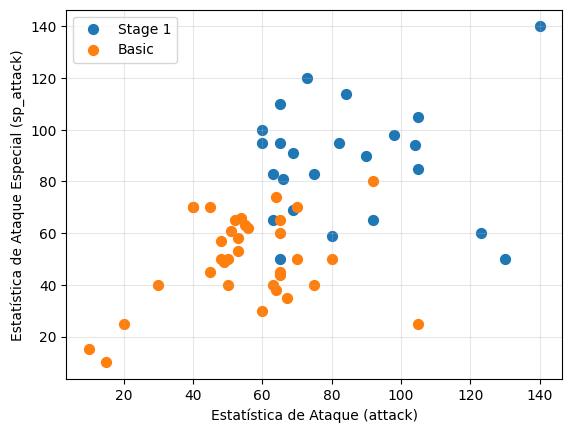

In [1034]:
for stage in set(y):
    plt.scatter(X[y == stage, 0], X[y == stage, 1], s=50, label=f'{stage}')
plt.xlabel('Estatística de Ataque (attack)')
plt.ylabel('Estatística de Ataque Especial (sp_attack)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

##### Algoritmo

A função plot_means() plota o gráfico de um algoritmo KMeans.

In [1035]:
def plot_kmeans(kmeans, X, y, feature_names, ypred_named, xlabel='X1',ylabel='X2'):
  plt.figure(figsize=(8,6))

  colors_real = ['orange', 'blue']
  colors_pred = ['darkorange', 'darkblue']

  for idx, feature in enumerate(feature_names):
    plt.scatter(X[y == feature, 0], X[y == feature, 1], s=100, label=f'{feature}', marker='s', color=colors_real[idx])

  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker="x", color="r", s=150, linewidths=7, label="Centroids")

  for idx, feature in enumerate(feature_names):
    plt.plot(X[ypred_named == feature, 0], X[ypred_named == feature, 1], ".", markersize=10, color=colors_pred[idx])

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()

O código abaixo é uma implementação do algoritmo KMeans. A função __fit()__ gera a quantidade de centroids iniciais em posições aleatórias definidas pelo usuário por meio da função **_init_centroids()**. Ao longo das iterações, a função __fit()__ aproxima os centroids de acordo com os elementos mais próximos pela distância Euclidiana calculada por **_distancias()**. O algoritmo completa o seu treinamento quando nenhum centroid se move de lugar.

<BR>
[PROBLEMA]

*O código KMeans_M() apresenta instablilidade. Caso o n_init seja definido em 1, o algoritmo irá executar como esperado, entretanto caso o n_init seja definido para que o modelo realize vários reinícios, ocorrerá problema de dimensionamento de matrix.*

In [1036]:
from sklearn.metrics import silhouette_score

class KMeans_I(BaseEstimator, ClusterMixin, TransformerMixin):
    def __init__(self, n_clusters=2, n_init=1):
        self.n_clusters = n_clusters
        self.n_init = n_init

    def _init_centroids(self, X):
        min_vals = np.min(X, axis=0)
        max_vals = np.max(X, axis=0)
        centroids = []
        for _ in range(self.n_clusters):
            centroid = [random.uniform(min_vals[j], max_vals[j]) for j in range(X.shape[1])]
            centroids.append(centroid)
        self.cluster_centers_ = np.array(centroids)

    def fit(self, X):
        best_sil_score = -1
        best_cluster_centers_ = None
        
        for _ in range(self.n_init):
            self._init_centroids(X)
            previous_centroids = self.cluster_centers_.copy()
            
            while True:
                ypred = self.predict(X)
                for i in range(self.n_clusters):
                    if np.any(ypred == i):
                        self.cluster_centers_[i] = np.mean(X[ypred == i], axis=0)
                
                if np.allclose(previous_centroids, self.cluster_centers_, atol=0.0001):
                    break
                previous_centroids = self.cluster_centers_.copy()
            
            sil_score = silhouette_score(X, ypred)
            if sil_score > best_sil_score:
                best_sil_score = sil_score
                best_cluster_centers_ = self.cluster_centers_.copy()
        
        self.cluster_centers_ = best_cluster_centers_
        self.labels_ = ypred
        return self

    def _distancias(self, X):
        diferenca = self.cluster_centers_ - X
        quadrado = diferenca ** 2
        soma = np.sum(quadrado, axis=1)
        raiz = np.sqrt(soma)
        return raiz

    def predict(self, X):
        distances = np.sqrt(((X - self.cluster_centers_[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)


Acurácia*: 0.915


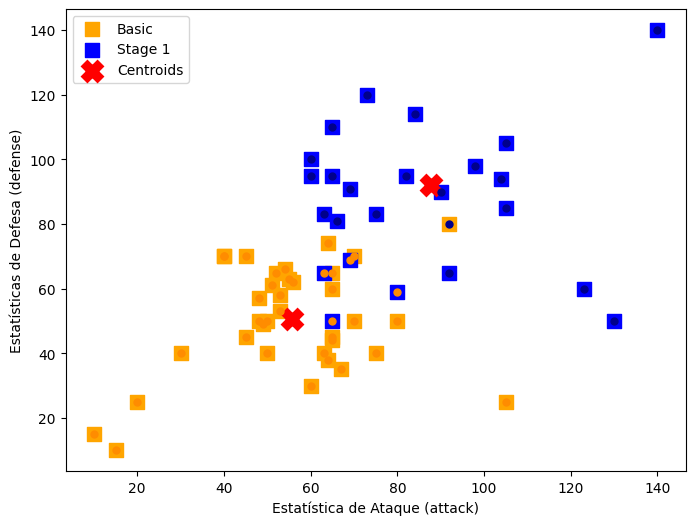

In [1037]:
stage_names = ['Basic', 'Stage 1']
ypred_n = np.array([])
kmeans_i = KMeans_I(n_clusters=2, n_init=50)
kmeans_i.fit(X)
ypred = kmeans_i.predict(X)

for i in range(len(ypred)):
  ypred_n = np.append(ypred_n, stage_names[int(ypred[i])])

print(f'Acurácia*: {accuracy_score(y, ypred_n):.3f}')

plot_kmeans(kmeans_i, X, y, stage_names, ypred_n, xlabel="Estatística de Ataque (attack)", ylabel="Estatísticas de Defesa (defense)" )

_* Como o KMeans é um modelo de aprendizagem não supervisionada, não é apropriado avaliar sua acurácia, pois não existem valores-alvo (y) com os quais as previsões (ypred) possam ser comparadas. A acurácia foi calculada e apresentada apenas para fornecer uma referência adicional._

<br>

Para analisar o desempenho do algoritmo implementado, abaixo é importado o modelo KMeans() da biblioteca Scikit-learn. Em tese, tanto a implementação manual quanto o modelo importado devem apresentar os mesmos resultados

In [1038]:
from sklearn.cluster import KMeans

O KMeans da biblioteca do Scikit-learn possui o parâmetro __n_init__. Ao definir um inteiro para esse parâmetro, o usuário indica ao algoritmo quantos reinícios aleatórios dos centroids poderá ser realizados. Basicamente o __n_init__ realiza a mesma lógica do loop implementado no KMeans_M() para buscar pela solução ótima possível.

Acurácia*: 0.915


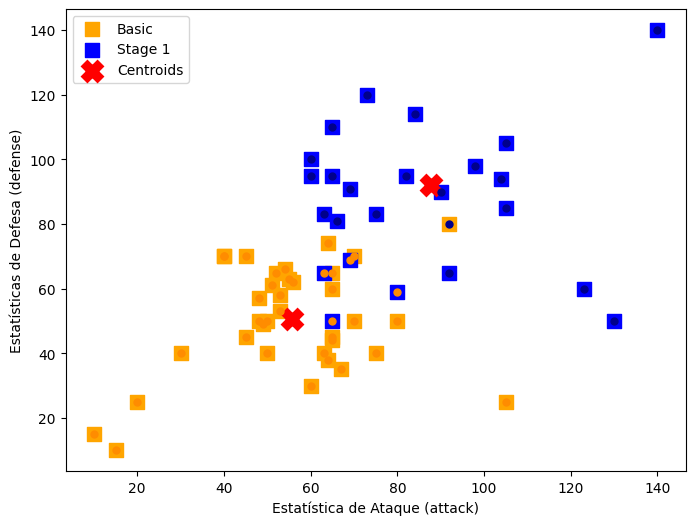

In [1039]:
ypred_n = np.array([])
kmeans = KMeans(n_clusters=2, n_init=100)
kmeans.fit(X)
ypred = kmeans.predict(X)

for i in range(len(ypred)):
  ypred_n = np.append(ypred_n, stage_names[int(ypred[i])])


print(f'Acurácia*: {accuracy_score(y, ypred_n):.3f}')

plot_kmeans(kmeans, X, y, stage_names, ypred_n, xlabel="Estatística de Ataque (attack)", ylabel="Estatísticas de Defesa (defense)" )

_* Como o KMeans é um modelo de aprendizagem não supervisionada, não é apropriado avaliar sua acurácia, pois não existem valores-alvo (y) com os quais as previsões (ypred) possam ser comparadas. A acurácia foi calculada e apresentada apenas para fornecer uma referência adicional._

<br>

### Ajuste dos Hiperparâmetros e Validação Cruzada

O algoritmo KMeans possui dois parâmetros bastante relevantes: **n_clusters** e **n_init**. O parâmetro n_clusters define a quantidade de centróides e, consequentemente, a quantidade de grupos a serem criados. Já o parâmetro **n_init** define quantas vezes o algoritmo será executado com diferentes centroids iniciais, a fim de encontrar a melhor classificação dos elementos.

Neste trabalho, não vamos testar valores os parâmetros para os Kmeans. O **n_clusters** teve ter seu valor definido em 2, pois queremos classificar os Pokémon em dois grupos (Basic ou Stage 1). Já o **n_init** só precisa ser o suficiênte para que todas as execuções resultem na solução ótima, e com alguns pequenos testes chegamos a conclusão que com 20 reinícios já seria o suficiente.

O modelo KMeans é um algoritmo de aprendizado de máquina não supervisionado, portando não é apropriado avaliar sua acurácia, porém existe uma métrica de avaliação capaz de quantificar o desempenho desse modelo. A métrica de __Silhouette Score__ mede o quão semelhante cada ponto de um cluster é em relação aos pontos do mesmo cluster (cohesão) em comparação com os pontos de outros clusters (separação).

In [1041]:
from sklearn.model_selection import cross_val_score

def silhouette_scorer(estimator, X):
    return silhouette_score(X, estimator.fit(X).predict(X))

kmeans_I = KMeans_I(n_clusters=2, n_init=20)
kmeans_sklearn = KMeans(n_clusters=2, n_init=20)


scores_kmeans_I = cross_val_score(kmeans_I, X, scoring=silhouette_scorer, cv=3)
scores_kmeans_sklearn = cross_val_score(kmeans_sklearn, X, scoring=silhouette_scorer, cv=3)

Valores de Silhouette próximos de 1 indicam que os clusters estão bem separados entre si, enquanto valores próximos de -1 sugerem uma má separação dos clusters. A média do Silhouette Score do modelo KMeans_M foi ligeiramente superior ao do modelo do Scikit-learn, sugerindo um desempenho um pouco melhor na definição dos clusters. No entanto, devido à pequena diferença observada e aos problemas identificados na implementação do KMeans_M, foi optado por utilizar o modelo do Scikit-learn na fase de captura e interpretação dos resultados.

In [1042]:
print(f"Média do Silhouette Score para KMeans_M (Implementado): {np.mean(scores_kmeans_I):.3f}")
print(f"Média do Silhouette Score para KMeans (Scikit-learn):   {np.mean(scores_kmeans_sklearn):.3f}")

Média do Silhouette Score para KMeans_M (Implementado): 0.494
Média do Silhouette Score para KMeans (Scikit-learn):   0.416


### Captura e Interpretação dos resultados

Na etapa anterior foi defino qual algoritmo (do Scikit-learn ou implementado) e os parâmetros ideais a serem ser utilizados no exercício de predição sem supervisão. Nesta etapa será realizada o treino e aplicado o teste do modelo.

In [1053]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

O KMeans (do Scikit-learn) alcançou o valor de 0.517 no Silhouette Scorer, indicando que os clusters conseguiram com certo sucesso dividor os dados de entrada em dois grupos.

In [1054]:
kmeans = KMeans(n_clusters=2, n_init=20)
kmeans.fit(X_train)
ypred = kmeans.predict(X_test)

ypred_n = np.array([])
for i in range(len(ypred)):
  ypred_n = np.append(ypred_n, stage_names[int(ypred[i])])

print(f'Silhouette Scorer: {silhouette_score(X_test, ypred):.3f}')

Silhouette Scorer: 0.517


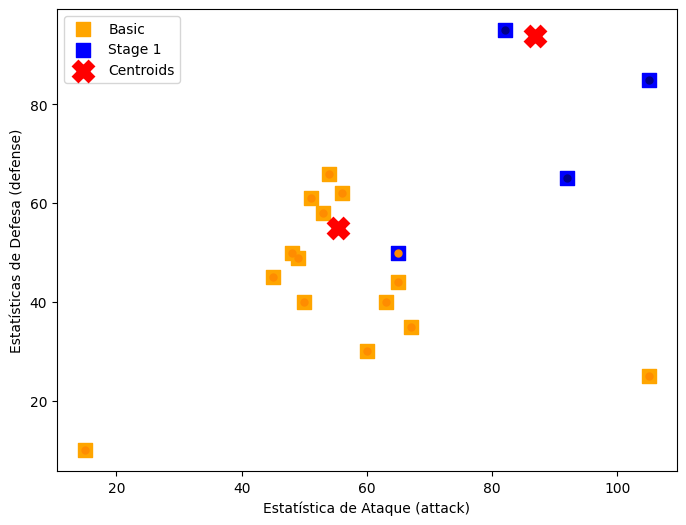

In [1055]:
plot_kmeans(kmeans, X_test, y_test, stage_names, ypred_n, 
            xlabel="Estatística de Ataque (attack)", 
            ylabel="Estatísticas de Defesa (defense)")

Os Pokémon do tipo Água (water) aumentam muitos pontos de estatísticas ao evoluirem para um novo estágio em comparação a outros tipos. O gráfico acima mostra a predição do modelo falhou em classificar somente 1 Pokémon, um ótimo feito para um modelo não supervisionado. 

<br>
<br>
<br>
<br>
<br>

***

# Redes Neurais

Os algoritmos de redes neurais são modelos de aprendizado de máquina que melhoram suas capacidades ao serem treinados com dados de entrada. Esses algoritmos ajustam seus parâmetros iterativamente, utilizando uma taxa de aprendizado, para minimizar o erro e otimizar a performance. Durante o treinamento, o modelo passa por várias iterações, ajustando continuamente os pesos e bias até alcançar resultados satisfatórios.

### Rede neurais lineares

Redes neurais lineares são uma forma simples de rede neural onde as funções de ativação das unidades (neurônios) são funções simples lineares, ou seja, as saídas são combinações lineares das entradas.


##### Tratamento dos Dados

Os dados de entrada (X) a serem utilizados para treinar o modelo de rede neural linear precisa ser linearmente separáveis para que seja possível que o  algoritmo treine e ache valores de pesos necessários.

Dentre os 18 tipos diferentes de Pokémon, há o tipo __Inseto__ e o __Dragão__. O tipo inseto é considerado, em média, o mais fraco quando a comparação é sobre estatísticas totais (total). Já o tipo dragão é o oposto, ele é o mais poderoso. Para avaliar a classificação linear, o bloco de código abaixo separa todos os Pokémon básicos (Basic) do tipo inseto (Bug) e todas as última evoluções dos Pokémon do tipo dragão (Dragon).

In [1056]:
selected_pkmn_stages = []


row_iter = data.iterrows()
current_index, current_pkmn = next(row_iter)

for next_index, next_pkmn in row_iter:
  if ((current_pkmn['type1'] == 'Bug' or current_pkmn['type2'] == 'Bug') and 
      current_pkmn['stage'] == 'Basic' and 
      (current_pkmn['attack'] + current_pkmn['sp_attack']) < 155):
    
    selected_pkmn_stages.append(current_pkmn)


  if ((current_pkmn['type1'] == 'Dragon' or current_pkmn['type2'] == 'Dragon') and 
      (next_pkmn['stage'] == 'Basic' or next_pkmn['stage'] == 'Baby') and 
      (current_pkmn['attack'] + current_pkmn['sp_attack']) > 165):
    
    selected_pkmn_stages.append(current_pkmn)

    
  current_index, current_pkmn = next_index, next_pkmn


selected_pkmn_stages = pd.DataFrame(selected_pkmn_stages, columns=['number', 'name', 'type1', 'type2', 'total', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'generation', 'legendary', 'stage'])

Para realizar a classificação dos dados, vamos separar as características __ataque__ e __ataque especial__ para serem os dados da variável independente (X) e o __tipo__ dos Pokémon para ser os dados da variável dependente (y).

In [1057]:
X = selected_pkmn_stages[['attack', 'sp_attack']].values

y = []
for _, pkmn in selected_pkmn_stages.iterrows():
  if pkmn['type1'] == 'Dragon' or pkmn['type1'] == 'Bug':
    y.append(pkmn['type1'])
  else:
    y.append(pkmn['type2'])

y = np.array([*y])

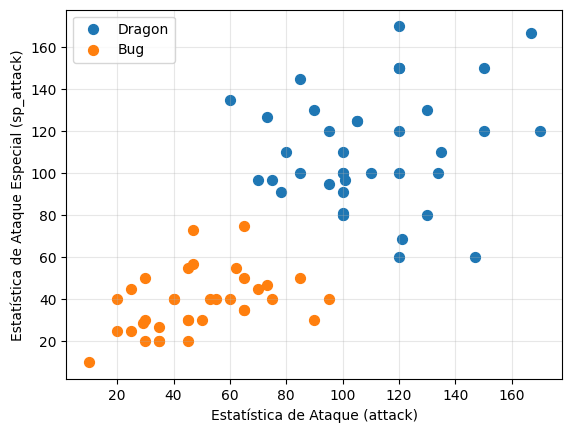

In [1058]:
for types in set(y):
    plt.scatter(X[y == types, 0], X[y == types, 1], s=50, label=f'{types}')
plt.xlabel('Estatística de Ataque (attack)')
plt.ylabel('Estatística de Ataque Especial (sp_attack)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

O Percetron é sensível a dados de grandes casas decimais. Para resolver esse problema basta padronizar os valores de X utilizando o StandarScaler().

In [1059]:
scale = StandardScaler()
X = scale.fit_transform(X)

Para realizar a comparação e a iteração do Perceptron, é necessário executar operações matemáticas específicas. Além disso, o Perceptron requer que os targets (y) estejam em formato de array Numpy. Portanto, é necessário criar uma função que converta os targets (y) em um array Numpy com valores 1 e -1.

In [1060]:
def binarize_y(y):
  reference = y[0]
  yb = []
  for elem in y:
    if elem == reference:
      yb.append(1)
    else:
      yb.append(-1)
  return np.array(yb)

In [1061]:
y = binarize_y(y)

##### Algoritmo

O código abaixo define funções para plotar um gráfico do Perceptron, um algoritmo de classificação. A função plot_perceptron exibe os dados de entrada e a linha de decisão do Perceptron, enquanto as funções perpendicular e plotahiperplano auxiliam na criação e plotagem dessa linha de decisão.

In [1062]:
def plot_perceptron(X, y, vetor, bias, labels):
  for i, types in enumerate(set(y)):
    plt.scatter(X[y == types, 0], X[y == types, 1], s=50, label=f'{labels[i]}')
  plt.xlabel('Estatística de Ataque (attack)')
  plt.ylabel('Estatística de Ataque Especial (sp_attack)')
  plotahiperplano(vetor, bias)
  plt.grid(alpha=0.3)
  plt.legend()


def perpendicular(vetor):
  rotaciona = np.array([[0,1],[-1,0]])
  perp = np.matmul(np.array(vetor), rotaciona)
  return perp

def plotahiperplano(vetor, bias):
  hiperplano = perpendicular(vetor)
  plt.arrow(*[0, bias], *(hiperplano - bias))

Esta classe implementa o ADALINE (ADAptive LInear NEuron), usa a soma dos erros ao quadrado para calcular o custo. No Perceptron tradicional, a função de ativação é aplicada diretamente ao produto interno dos pesos e das entradas para obter a previsão. No Adaline, a atualização dos pesos é baseada na preativação (o produto interno sem a função de ativação). O ADALINE será a classe do calculo do custo e do gradiente do Perceptron neste trabalho.

In [1063]:
class Adaline():
    def __init__(self):
        self.preactivated = True

    @staticmethod
    def erro(y, ypred):
        return y - ypred
    
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - Adaline.erro(y, ypred)) ** 2)
    
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(Adaline.erro(y, ypred), X)

O código abaixo é a implementação do modelo Perceptron.

In [1069]:
class Perceptron_I(BaseEstimator, ClassifierMixin):
    def __init__(self, custo=Adaline(), alpha=0.01, max_iter = 1000):
        self.w = None
        self.activation = lambda a: (a >= 0) * 2 - 1
        self.alpha = alpha
        self.max_iter = max_iter
        self.custo = custo

    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        return Xb

    def fit(self, X, y):
        Xb = Perceptron_I.includebias(X)
        self.w = np.random.uniform(-1, 1, size=Xb.shape[1])
        for _ in range(self.max_iter):
            if hasattr(self.custo, 'preactivated') and self.custo.preactivated: 
                ypred = self.preactivate(X) 
            else:
                ypred = self.predict(X)
            custo = self.custo.custo(y, ypred)
            if custo == 0:
                break
            self.w = self.w + self.alpha * self.custo.gradiente(y, ypred, Xb)

    def preactivate(self, X):
        Xb = Perceptron_I.includebias(X)
        return np.matmul(Xb, self.w)

    def predict(self, X):
        a = self.preactivate(X)
        ypred = self.activation(a)
        return ypred

Acurácia:  1.0
Pesos(w): -0.348 e -0.593
Bias:     -0.054


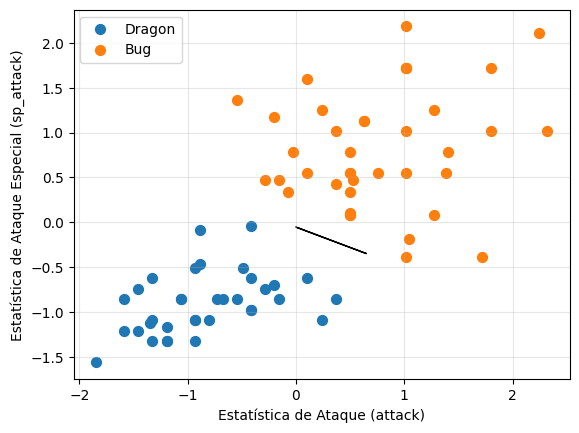

In [1070]:
perceptron_I = Perceptron_I()
perceptron_I.fit(X, y)
ypred = perceptron_I.predict(X)


print(f'Acurácia:  {accuracy_score(y, ypred)}')
print(f'Pesos(w): {perceptron_I.w[1]:.3f} e {perceptron_I.w[2]:.3f}\nBias:     {perceptron_I.w[0]:.3f}')

labels = ['Dragon','Bug']
plot_perceptron(X, y, perceptron_I.w[1:], perceptron_I.w[0], labels=labels)

No bloco de código abaixo importa o algoritmo do Percepntron da biblioteca do Scikit-learn.

In [1071]:
from sklearn.linear_model import Perceptron

Acurácia:  1.0
Pesos(w): -2.238 e -2.131
Bias:     0.000


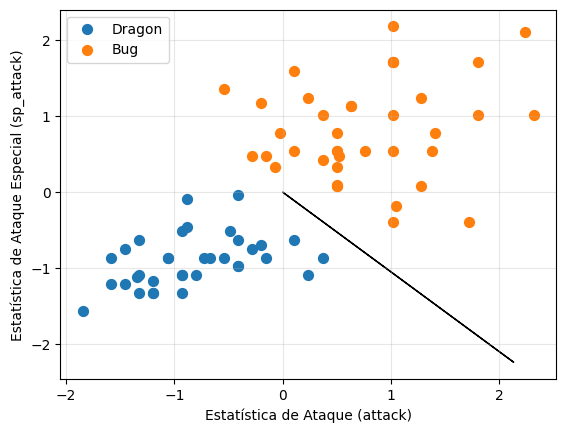

In [1072]:
perceptron = Perceptron(fit_intercept=True)
perceptron.fit(X, y)
ypred = perceptron.predict(X)


print(f'Acurácia:  {accuracy_score(y, ypred)}')
print(f'Pesos(w): {perceptron.coef_[0][0]:.3f} e {perceptron.coef_[0][1]:.3f}\nBias:     {perceptron.intercept_[0]:.3f}')

labels = ['Dragon','Bug']
plot_perceptron(X, y, perceptron.coef_[0], perceptron.intercept_[0], labels=labels)

##### Ajuste dos Hiperparâmetros e Validação Cruzada

O algoritmo Percentron possui 2 parâmetros: o __alpha__ que define a taxa de aprendizado dos pesos (w) em cada iteração, e o __max_iter__ que define a quantidade máxima de iteração que o algoritmo poderá realizar.

In [1073]:
parameters = {
  'alpha': [0.0001, 0.001, 0.01, 0.1],
  'max_iter': [10, 50, 100, 150]
  }

gs_per_I_model = GridSearchCV(Perceptron_I(), parameters, scoring="accuracy")
perceptron_I_scores = cross_validate(gs_per_I_model, X, y, scoring="accuracy", cv=5)

gs_per_model = GridSearchCV(Perceptron(), parameters, scoring="accuracy")
perceptron_scores = cross_validate(gs_per_model, X, y, scoring="accuracy", cv=5)

Os resultados do desempenho médio da acurácia dos algoritmos Perceptron revelam que ambos os dois algoritmos são suficientes para o problema. Portanto será escolhido o modelo importado do Scikit-learn.

In [1074]:
per_I_mean = perceptron_I_scores['test_score'].mean()
per_mean = perceptron_scores['test_score'].mean()

print(f'Desempenho médio de acurácia da KNeighborsClassifier (implementado): {per_I_mean:.3f}')
print(f'Desempenho médio de acurácia da KNeighborsClassifier (Scikit-learn): {per_mean:.3f}')

Desempenho médio de acurácia da KNeighborsClassifier (implementado): 1.000
Desempenho médio de acurácia da KNeighborsClassifier (Scikit-learn): 1.000


Após a escolha do modelo, é necessário determinar qual configuração de parâmetros gera os melhores resultados. Ao utilizar o GridSearchCV, concluiu-se que o parâmetro __alpha__ com valor __0.0001__ e __max_iter__ com valor __10__ resultaram na melhor acurácia entre as opções testadas. Observa-se que os valores que formam a melhor configuração dos parâmetros são os menores valores, sendo os primeiros a serem testados. Isso demonstra que o algoritmo é bastante eficaz quando os dados são linearmente separáveis.

In [1075]:
gs_per_model.fit(X,y)
gs_per_model.best_params_, gs_per_model.best_score_

({'alpha': 0.0001, 'max_iter': 10}, 1.0)

##### Captura e Interpretação dos resultados

Na etapa anterior foi definido qual o algoritmo a ser utilizado (do Scikit-learn ou implementado) e os parâmetros ideais para o exercício de classificação. Nesta etapa será realizado o treinamento e aplicado o teste do modelo.

In [1076]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1077]:
perceptron = Perceptron(fit_intercept=True)
perceptron.fit(X_train, y_train)
ypred = perceptron.predict(X_test)

Acurácia:  1.0
Pesos(w): -1.821 e -1.171
Bias:     0.000


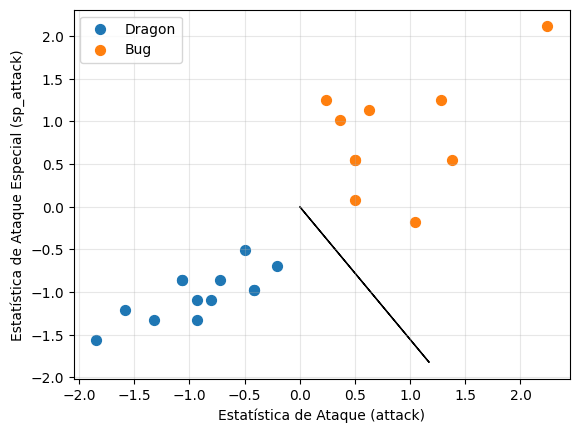

In [1078]:
print(f'Acurácia:  {accuracy_score(y_test, ypred)}')
print(f'Pesos(w): {perceptron.coef_[0][0]:.3f} e {perceptron.coef_[0][1]:.3f}\nBias:     {perceptron.intercept_[0]:.3f}')

labels = ['Dragon','Bug']
plot_perceptron(X_test, y_test, perceptron.coef_[0], perceptron.intercept_[0], labels=labels)

Os dados de entrada foram escolhidos com o único objetivo de possui dados linearmente separáveis, portanto não terá informações anaĺiticas sobre a relação dos dados.

<br>
<br>
<br>
<br>
<br>

### Rede neurais com Camada Oculta

Redes neurais com camadas ocultas são uma extensão dos modelos de redes neurais simples, como Perceptron. Elas são capazes de aprender representações mais complexas dos dados devido à adição de uma ou mais camadas entre a camada de entrada e a camada de saída, conhecidas como camadas ocultas.

##### Tratamento dos Dados

Os dados de entrada (X) a serem utilizados para treinar o modelo de rede neural linear precisa ser linearmente separáveis para que seja possível que o  algoritmo treine e ache valores de pesos necessários.

Dentre os 18 tipos diferentes de Pokémon, há o tipo __Inseto__ e o __Dragão__. O tipo inseto é considerado, em média, o mais fraco quando a comparação é sobre estatísticas totais (total). Já o tipo dragão é o oposto, ele é o mais poderoso. Para avaliar a classificação linear, o bloco de código abaixo separa todos os Pokémon básicos (Basic) do tipo inseto (Bug) e todas as última evoluções dos Pokémon do tipo dragão (Dragon).

In [1079]:
selected_pkmn = data.loc[data['legendary'] == True]

Para realizar a comparação e a iteração do Perceptron, é necessário executar operações matemáticas específicas. Além disso, o Perceptron requer que os targets (y) estejam em formato de array Numpy. Portanto, é necessário criar uma função que converta os targets (y) em um array Numpy com valores 1 e -1.

In [1080]:
X = selected_pkmn[['attack', 'sp_attack']].values

y = np.array([])
for index, pkmn in selected_pkmn.iterrows():
  isDragon_or_Psychic = int((pkmn['type1'] == 'Dragon' or pkmn['type2'] == 'Dragon') or 
                            (pkmn['type1'] == 'Psychic' or pkmn['type2'] == 'Psychic'))
  if isDragon_or_Psychic == 0:
    isDragon_or_Psychic = -1
  y = np.append(y, isDragon_or_Psychic)

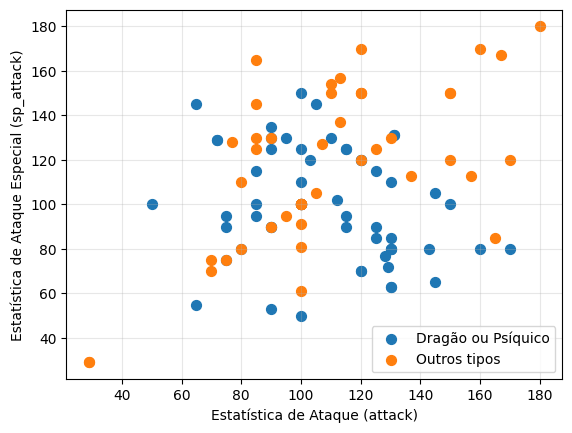

In [1082]:
label_map = {-1: 'Dragão ou Psíquico', 1: 'Outros tipos'}

for label in label_map:
    plt.scatter(X[y == label, 0], X[y == label, 1], s=50, label=label_map[label])

plt.xlabel('Estatística de Ataque (attack)')
plt.ylabel('Estatística de Ataque Especial (sp_attack)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

O Percetron é sensível a dados de grandes casas decimais. Para resolver esse problema basta padronizar os valores de X utilizando o StandarScaler().

In [1083]:
scale = StandardScaler()
X = scale.fit_transform(X)

##### Algoritmo

O código abaixo define funções para plotar um gráfico do Perceptron, um algoritmo de classificação. A função plot_perceptron exibe os dados de entrada e a linha de decisão do Perceptron, enquanto as funções perpendicular e plotahiperplano auxiliam na criação e plotagem dessa linha de decisão.

In [1106]:
def plot_dataset(X, y, label_map, alpha=0.3):
  for label in label_map:
    plt.scatter(X[y == label, 0], X[y == label, 1], s=50, label=label_map[label])

  plt.xlabel('Estatística de Ataque (attack)')
  plt.ylabel('Estatística de Ataque Especial (sp_attack)')
  plt.grid(alpha)
  plt.legend()

def define_axes(X):
  offset = 0.5
  min1, max1 = X[:, 0].min(), X[:, 0].max()
  min2, max2 = X[:, 1].min(), X[:, 1].max()
  return [min1-offset, max1+offset, min2-offset, max2+offset]

def plot_mlpclassifier(clf, X):
  axes = define_axes(X)
  x0s = np.linspace(axes[0], axes[1], 100)
  x1s = np.linspace(axes[2], axes[3], 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  X = np.c_[x0.ravel(), x1.ravel()]
  y_pred = clf.predict(X).reshape(x0.shape)
  plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [1085]:
def sign(a):
  return (a>0) * 2 - 1

In [1086]:
def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

In [1087]:
from scipy.special import expit

def tanh(a):
  return expit(a)*2-1

In [1089]:
class MLPClassifier_I(BaseEstimator, ClassifierMixin):
  def __init__(self, hidden_layer_sizes=[100], max_iter=200, learning_rate_init=0.0001):
    self.max_iter = max_iter
    self.learning_rate_init = learning_rate_init
    self.hidden_layer_sizes = hidden_layer_sizes

  def forward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    for W in self.Ws:
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      AUX = tanh(self.Z[-1])
    return AUX
  
  def backward(self, X, y, ypred):
    grads = []
    output_delta = y.reshape(-1,1) - ypred.reshape(-1,1)
    grads.insert(0,self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1,0, -1):
      tanh_grad = (1- np.square(tanh(self.Z[i-1])))
      input_delta = (output_delta @ self.Ws[i][1:,:].T) * tanh_grad
      grads.insert(0,self.A[i-1].T @ input_delta)
      output_delta = input_delta.copy()

    for i in range(len(self.Ws)-1, -1, -1):
      self.Ws[i] += grads[i] * self.learning_rate_init

  def fit(self, X, y):
    self.Ws = []
    previous_output = X.shape[1]
    for layer_size in self.hidden_layer_sizes:
      self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
      previous_output = self.Ws[-1].shape[1]
    self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, 1)))
    for _ in range(self.max_iter):
      ypred = self.forward(X)
      self.backward(X, y, ypred)

  def predict(self, X):
    return sign(self.forward(X))

Acurácia: 0.7830188679245284


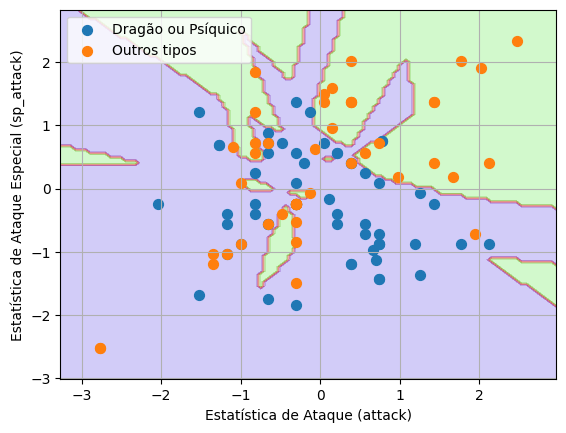

In [1107]:
mlpclassifier_I = MLPClassifier_I(hidden_layer_sizes=[30], 
                                  max_iter=500, 
                                  learning_rate_init=0.1)
mlpclassifier_I.fit(X, y)
ypred = mlpclassifier_I.predict(X)

print(f'Acurácia: {accuracy_score(y, ypred)}')

plot_mlpclassifier(mlpclassifier_I, X)
plot_dataset(X,y, label_map = {-1: 'Dragão ou Psíquico', 1: 'Outros tipos'}, alpha=1)

No bloco de código abaixo importa o algoritmo do Percepntron da biblioteca do Scikit-learn.

In [1094]:
from sklearn.neural_network import MLPClassifier

Acurácia: 0.8018867924528302


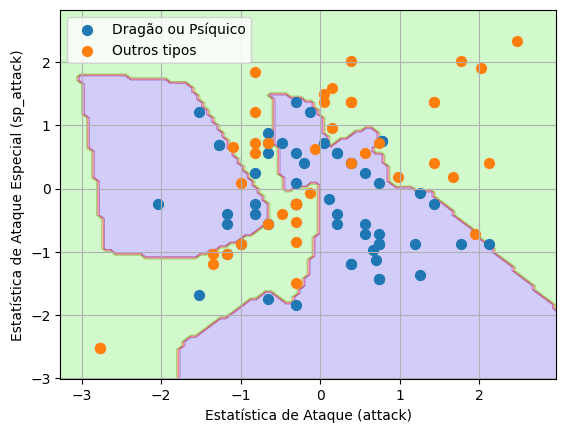

In [1108]:
mlpclassifier = MLPClassifier(hidden_layer_sizes=[30], 
                                  max_iter=500, 
                                  learning_rate_init=0.1)
mlpclassifier.fit(X, y)
ypred = mlpclassifier.predict(X)

print(f'Acurácia: {accuracy_score(y, ypred)}')

plot_mlpclassifier(mlpclassifier, X)
plot_dataset(X,y, label_map = {-1: 'Dragão ou Psíquico', 1: 'Outros tipos'}, alpha=1)

##### Ajuste dos Hiperparâmetros e Validação Cruzada

O algoritmo Percentron possui 2 parâmetros: o __alpha__ que define a taxa de aprendizado dos pesos (w) em cada iteração, e o __max_iter__ que define a quantidade máxima de iteração que o algoritmo poderá realizar.

ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

In [1282]:
parameters = {
  'hidden_layer_sizes': [[10, 10, 10], [50,50,50], [100,100,100]],
  'max_iter': [1000],
  'learning_rate_init': [0.001, 0.01, 0.1]
  }

gs_mlpc_I_model = GridSearchCV(MLPClassifier_I(), parameters, scoring="accuracy")
mlpclassifier_I_scores = cross_validate(gs_mlpc_I_model, X, y, scoring="accuracy", cv=5)

gs_mlpc_model = GridSearchCV(MLPClassifier(activation='tanh'), parameters, scoring="accuracy")
mlpclassifier_scores = cross_validate(gs_mlpc_model, X, y, scoring="accuracy", cv=5)

/home/douglas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-pac

Os resultados do desempenho médio da acurácia dos algoritmos Perceptron revelam que ambos os dois algoritmos são suficientes para o problema. Portanto será escolhido o modelo importado do Scikit-learn.

In [1285]:
mlpc_I_mean = mlpclassifier_I_scores['test_score'].mean()
mlpc_mean = mlpclassifier_scores['test_score'].mean()

print(f'Desempenho médio de acurácia da KNeighborsClassifier (implementado): {mlpc_I_mean:.3f}')
print(f'Desempenho médio de acurácia da KNeighborsClassifier (Scikit-learn): {mlpc_mean:.3f}')

Desempenho médio de acurácia da KNeighborsClassifier (implementado): 0.614
Desempenho médio de acurácia da KNeighborsClassifier (Scikit-learn): 0.557


Após a escolha do modelo, é necessário determinar qual configuração de parâmetros gera os melhores resultados. Ao utilizar o GridSearchCV, concluiu-se que o parâmetro __alpha__ com valor __0.0001__ e __max_iter__ com valor __10__ resultaram na melhor acurácia entre as opções testadas. Observa-se que os valores que formam a melhor configuração dos parâmetros são os menores valores, sendo os primeiros a serem testados. Isso demonstra que o algoritmo é bastante eficaz quando os dados são linearmente separáveis.

In [1248]:
gs_mlpc_model.fit(X,y)
gs_mlpc_model.best_params_, gs_mlpc_model.best_score_

/home/douglas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site

({'hidden_layer_sizes': [10], 'learning_rate_init': 0.1, 'max_iter': 1000},
 0.6696969696969697)

##### Captura e Interpretação dos resultados

Na etapa anterior foi definido qual o algoritmo a ser utilizado (do Scikit-learn ou implementado) e os parâmetros ideais para o exercício de classificação. Nesta etapa será realizado o treinamento e aplicado o teste do modelo.

In [1312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Acurácia: 0.59375


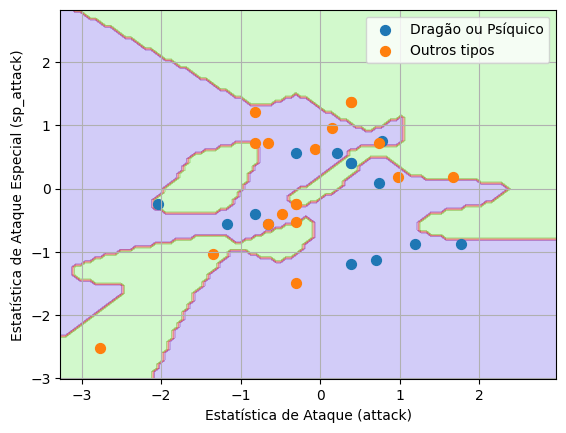

In [1313]:
mlpclassifier = MLPClassifier(hidden_layer_sizes=[50], 
                                  max_iter=1000, 
                                  learning_rate_init=0.1, activation='tanh')
mlpclassifier.fit(X_train, y_train)
ypred = mlpclassifier.predict(X_test)

print(f'Acurácia: {accuracy_score(y_test, ypred)}')

plot_mlpclassifier(mlpclassifier, X)
plot_dataset(X_test,y_test, label_map = {-1: 'Dragão ou Psíquico', 1: 'Outros tipos'}, alpha=1)

Os dados de entrada foram escolhidos com o único objetivo de possui dados linearmente separáveis, portanto não terá informações anaĺiticas sobre a relação dos dados.

<br>
<br>
<br>
<br>
<br>

***

# Técnica de Ensemble

Ensemble learning, ou aprendizado em conjunto, é uma técnica de aprendizado de máquina onde múltiplos modelos são treinados e combinados para resolver um determinado problema de classificação ou regressão. A lógica por trás dessa técnica é que cada algoritmo pode ter pontos fortes diferentes, e ao explorar esses pontos fortes, o aprendizado se torna muito mais eficiente. Neste trabalho, utilizaremos quatro três técnicas e compararemos o desempenho entre elas.

A análise de desempenho das técnicas de Ensemble não incluirá uma análise detalhada sobre o conteúdo dos dados de entrada (X) e dos valores de target (y). O objetivo principal desta etapa do trabalho é exclusivamente demonstrar a diferença de desempenho entre os algoritmos individualmente e as técnicas de Ensemble.

### Voting

##### Tratamento dos dados

Os dados de entrada selecionados pelo código abaixo têm como objetivo dificultar o processo de aprendizagem dos algoritmos que serão testados nesta etapa, mas ainda permitir que os modelos consigam realizar predições.

In [693]:
selected_pkmn = data.loc[
    (data['type1'] == 'Fighting') &
    (data['type2'].isnull())
]
X = selected_pkmn[['hp', 'speed']].values
y = selected_pkmn['stage'].values

In [694]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### Algoritmo

Voting é uma técnica de ensemble que combina múltiplos modelos para fazer previsões utilizando votação. Cada modelo usado em um Voting apresenta seu resultado individual, ou seja, seu voto na votação.

Abaixo, mostramos o desempenho de acurácia de cada modelo de aprendizagem de máquina quando executado individualmente.

In [702]:
models_in_voting = [LogisticRegression(max_iter=999),
                    KNeighborsClassifier(n_neighbors=7),
                    DecisionTreeClassifier()]


models_v_accuracy = []
for model in models_in_voting:
  model.fit(X_train, y_train)
  ypred = model.predict(X_test)
  models_v_accuracy.append(accuracy_score(y_test, ypred))
  

for i, acc in enumerate(models_v_accuracy):
  print(f'{models_in_voting[i]}: {acc:.3f}')

LogisticRegression(max_iter=999): 0.556
KNeighborsClassifier(n_neighbors=7): 0.667
DecisionTreeClassifier(): 0.556


In [703]:
from sklearn.ensemble import VotingClassifier

votingclassifier = VotingClassifier([
  ('logisticregression', LogisticRegression(max_iter=999)),
  ('knc', KNeighborsClassifier(n_neighbors=7)),
  ('treeclassifier', DecisionTreeClassifier())
])

In [704]:
votingclassifier.fit(X_train, y_train)
voting_pred = votingclassifier.predict(X_test)
accuracy_score(y_test, voting_pred)

0.6666666666666666

### Bagging

##### Tratamento dos dados

In [84]:
selected_pkmn = data.loc[
    (data['type1'] == 'Electric') |
    (data['type1'] == 'Steel')
]

X = selected_pkmn[['hp', 'attack', 'defense','sp_attack', 'sp_defense', 'speed']]
y = selected_pkmn['type1']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### Algoritmo

In [86]:
treeclassifier = DecisionTreeClassifier()

treeclassifier.fit(X_train, y_train)
ypred = treeclassifier.predict(X_test)

print(f'Árvore de decisão: {accuracy_score(y_test, ypred):.3f}')

Árvore de decisão: 0.821


In [87]:
from sklearn.ensemble import BaggingClassifier

In [88]:
bagging_tree = BaggingClassifier(DecisionTreeClassifier(), random_state=42, n_estimators=1000)

bagging_tree.fit(X_train, y_train)
ypred = bagging_tree.predict(X_test)
print(f'Bagging (DecisionTreeClassifier): {accuracy_score(y_test, ypred):.3f}')

Bagging (DecisionTreeClassifier): 0.929


### Staking

##### Tratamento dos dados

In [133]:
selected_pkmn = data.loc[
    (data['type1'] == 'Water') &
    (data['type2'].isnull())
]
X = selected_pkmn[['attack', 'sp_attack']].values
y = selected_pkmn['stage'].values

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=42)

##### Algoritmo

In [707]:
from sklearn.ensemble import VotingClassifier

votingclassifier = VotingClassifier([
  ('logisticregression', LogisticRegression(max_iter=9999)),
  ('knc', KNeighborsClassifier(n_neighbors=7)),
  ('treeclassifier', DecisionTreeClassifier())
])

In [708]:
votingclassifier.fit(X_train, y_train)
voting_pred = votingclassifier.predict(X_test)
accuracy_score(y_test, voting_pred)

0.6666666666666666

In [709]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

stackingclass = StackingClassifier([
  ('voting', votingclassifier),
  ('perceptron', RandomForestClassifier(random_state=42))
 ], cv=3, passthrough=True)

In [710]:
stackingclass.fit(X, y)
staking_pred = stackingclass.predict(X)
accuracy_score(y, staking_pred)

/home/douglas/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1116: RuntimeWarning: Number of classes in training fold (3) does not match total number of classes (4). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/home/douglas/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

0.7931034482758621